## NARX SST Región Niño 3.4

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

In [1]:
from MONGO import CONEXION
from datetime import datetime
import pandas as pd
import numpy as np

from tensorflow import keras

# Creando Coenxión con Mongo DB

In [2]:
# Creando la conexión con MongoDB
db = CONEXION.conexion()
db.list_collection_names()

['polygons', 'meteorological', 'SSTNino34']

# Descargando la Información SST NIÑO3.4

In [3]:
# Fecha actual
time = datetime.today().toordinal()

# Realizando consulta
sst_data = db.SSTNino34.find({"time":{"$lte":time}})

# Generando pandas dataframe
data_pandas = pd.DataFrame([file for file in sst_data])
data_pandas['periodo'] = data_pandas.time.apply(lambda x: datetime.fromordinal(x))
data_pandas['mes_year'] =  data_pandas['periodo'].dt.strftime('%B-%Y')
data_pandas.index = pd.to_datetime(data_pandas.periodo)
data_pandas.head(10)

,_id,year,month,nino34_mean,climatologica,anomalias,mes,time,time_actualizacion,periodo,mes_year
periodo,,,,,,,,,,,
2022-06-01,62e6d1d870bebdf1983a27a9,2022,6,26.96,27.73,-0.77,junio,738307,738367,2022-06-01,June-2022
2022-05-01,62e6d1d870bebdf1983a27a8,2022,5,26.82,27.94,-1.12,mayo,738276,738367,2022-05-01,May-2022
2022-04-01,62e6d1d870bebdf1983a27a7,2022,4,26.71,27.83,-1.12,abril,738246,738367,2022-04-01,April-2022
2022-03-01,62e6d1d870bebdf1983a27a6,2022,3,26.32,27.29,-0.98,marzo,738215,738367,2022-03-01,March-2022
2022-02-01,62e6d1d870bebdf1983a27a5,2022,2,25.87,26.76,-0.90,febrero,738187,738367,2022-02-01,February-2022
2022-01-01,62e6d1d870bebdf1983a27a4,2022,1,25.60,26.55,-0.95,enero,738156,738367,2022-01-01,January-2022
2021-12-01,62e6d1d870bebdf1983a27a3,2021,12,25.54,26.60,-1.06,diciembre,738125,738367,2021-12-01,December-2021
2021-11-01,62e6d1d870bebdf1983a27a2,2021,11,25.76,26.70,-0.94,noviembre,738095,738367,2021-11-01,November-2021
2021-10-01,62e6d1d870bebdf1983a27a1,2021,10,25.78,26.72,-0.94,octubre,738064,738367,2021-10-01,October-2021


In [4]:
# Registros
print(data_pandas.shape)
# Data disponible
print(data_pandas.index.min())
print(data_pandas.index.max())

(870, 11)
1950-01-01 00:00:00
2022-06-01 00:00:00


# CLASS NARX

In [5]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from tensorflow import keras


class KERAS_NARX:

    """
    Clase para el entrenamiento de modelos Keras
    """

    def __init__(self,pd_model, y_output, exogena, prediction_order, auto_order, exog_order, exog_delay):
        self.pd_model = pd_model[ [y_output] + exogena].sort_index(ascending=True)
        self.y_output = y_output
        self.exogena = exogena
        self.prediction_order = prediction_order
        self.auto_order = auto_order
        self.exog_order = exog_order
        self.exog_delay = exog_delay


    def split_data(self):
        """
        Funcion para determinar la data de entrenamiento
        """

        self.data_test = self.pd_model[:-self.prediction_order]
        self.input_data, self.output_data = self.date_window(pd_model = self.data_test,
                                        auto_order = self.auto_order,
                                        exog_order = self.exog_order,
                                        exog_delay = self.exog_delay,
                                        exogena = self.exogena,
                                        output = self.y_output)

        # Neuronas capa entrada
        _ , self.ninp = self.input_data.shape


    def training_model(self, model, epochs, validation_split, callbacks):
        """
        Funcion para el Entrenamiento del modelo Keras
        """

        self.model = model
        self.epochs = epochs
        self.validation_split = validation_split
        self.callbacks = callbacks

        self.history = self.model.fit(x=self.input_data,
                                    y=self.output_data,
                                    epochs=self.epochs,
                                    verbose=0,
                                    validation_split=self.validation_split,
                                    callbacks=self.callbacks
                                    )


    def loss_plot(self,title,path):
        """
        Funcion para la visualizacion de la perdida
        """

        self.visualizar_perdida(history=self.history, title=title, path=path)


    def validation_test(self,batch_size):

        """
        Funcion para estudiar resultados
        """

        self.batch_size = batch_size

        # Prediccion para entrenamiento
        prediction_test = model.predict(self.input_data,
                                        batch_size=self.batch_size,
                                        verbose=0,
                                        steps=None,
                                        callbacks=None,
                                        max_queue_size=10,
                                        workers=1,
                                        use_multiprocessing=False)

        # Guardando predicciones
        self.pd_validation = self.pd_model.copy().reset_index(drop=False)
        self.pd_validation['prediction'] = np.nan
        self.pd_validation['type'] = 'training'
        self.pd_validation.loc[ self.data_test.shape[0]: , 'type' ] = 'validation'

        # Prediccion training
        self.pd_validation.loc[ range(max(self.auto_order, self.exog_order),(self.data_test.shape[0])), 'prediction' ] = prediction_test

        # Generando auto predicion
        pd_selfPrediction = self.data_test.copy()
        pd_selfPrediction['type'] = 'historical'

        for x in range(self.prediction_order):
            selfPrediction = self.forecast_one_step( data=pd_selfPrediction.copy(),
                                                model=self.model,
                                                auto_order=self.auto_order,
                                                exog_order=self.exog_order,
                                                exog_delay=self.exog_delay,
                                                exogena=self.exogena,
                                                y_output=self.y_output,
                                                batch_size=self.batch_size)

            selfPrediction[self.exogena] = selfPrediction[self.y_output]

            pd_selfPrediction = pd.concat([pd_selfPrediction, selfPrediction]).copy()  

        self.pd_validation.loc[ self.data_test.shape[0]: , 'prediction' ] = pd_selfPrediction[-self.prediction_order:][self.y_output].to_numpy()



    #--
    def forecast_one_step(self,data,model,auto_order,exog_order,exog_delay,exogena,y_output,batch_size):
        """
        Funcion para la prediccion a one step
        """

        # Pandas Data Frame
        pd_update = pd.DataFrame()
        # Agregando Index 
        pd_update['periodo'] = pd.to_datetime([ (data.index.max() + pd.DateOffset(months=1) ).strftime('%Y-%m')])
        pd_update = pd_update.set_index('periodo')
        #print(pd_update.index )
        pd_update[y_output] = np.nan
        for col in exogena:
            pd_update[col] = np.nan

        pd_update['type'] = 'self_prediction'

        # Formato a los datos
        input_data_validate, _ = self.date_window(pd_model=data.copy(),
                                            auto_order=auto_order,
                                            exog_order=exog_order,
                                            exog_delay=exog_delay,
                                            exogena=exogena,
                                            output=y_output)

        # Data para pronostico
        past_row = input_data_validate[-1].reshape(1, input_data_validate.shape[1])

        # prediccion
        prediction_validation = model.predict(  past_row,
                                                batch_size=batch_size,
                                                verbose=0,
                                                steps=None,
                                                callbacks=None,
                                                max_queue_size=10,
                                                workers=1,
                                                use_multiprocessing=False)

        pd_update[y_output] = prediction_validation.flat[0]

        return pd_update

    #--
    @staticmethod
    def date_window(pd_model,auto_order,exog_order,exog_delay,exogena,output):
        """
        Funcion para estructurar los datos de entrada del modelo NARX
        """

        X = pd_model[exogena].to_numpy().astype(float)
        y = pd_model[[output]].to_numpy().astype(float)

        # Data para el mmodelo
        input_data = []
        output_data = []
        for t in range(max(auto_order, exog_order), len(y)):
            input_data.append(np.concatenate((y[(t - auto_order + 1):(t + 1)], X[(t - exog_delay - exog_order + 1):(t - exog_delay + 1)]), axis=0) )
            output_data.append(np.array(y[t]))

        # Input del modelo
        input_data = np.array(input_data)
        # Output del modelo
        output_data = np.array(output_data)

        return (input_data.reshape(input_data.shape[0],input_data.shape[1]), output_data)

    #--
    @staticmethod
    def visualizar_perdida(history, title, path):
        """
        Funcion para visualizar la funcion de perdida de la red NARX
        """
        params = {'legend.fontsize': 'x-large',
                #'figure.figsize': (15, 10),
                'axes.labelsize': 'x-large',
                'axes.titlesize':'x-large',
                'xtick.labelsize':'x-large',
                'ytick.labelsize':'x-large'}

        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs = range(len(loss))
        plt.figure(figsize=(15,10))
        pylab.rcParams.update(params)
        plt.plot(epochs, loss, "b", label="Entrenamiento")
        plt.plot(epochs, val_loss, "r", label="Validación")
        
        plt.title('Pérdida en el entrenamiento y validación',loc='left',fontsize=18)
        plt.suptitle(title,ha='left',fontsize=30,x=0.12)
        plt.xlabel("Épocas",fontsize=18)
        plt.ylabel("Pérdida",fontsize=18)
        plt.legend()

        plt.savefig(path)

        plt.show()

Aplicando transformación

In [6]:
# Data modelo
data_model = data_pandas[['nino34_mean']].dropna().copy()

data_mean = data_model.mean()
data_std = data_model.std()


data_model['t_nino34_mean'] = (data_model['nino34_mean'] - data_mean[data_mean.index=='nino34_mean'][0])/data_std[data_std.index=='nino34_mean'][0]
data_model['t_nino34_mean_exogena'] = data_model['t_nino34_mean'] 

data_model

,nino34_mean,t_nino34_mean,t_nino34_mean_exogena
periodo,,,
2022-06-01,26.96,0.069877,0.069877
2022-05-01,26.82,-0.073069,-0.073069
2022-04-01,26.71,-0.185383,-0.185383
2022-03-01,26.32,-0.583588,-0.583588
2022-02-01,25.87,-1.043056,-1.043056
...,...,...,...
1950-05-01,26.19,-0.716323,-0.716323
1950-04-01,26.29,-0.614219,-0.614219
1950-03-01,25.88,-1.032845,-1.032845


Definiendo datos

In [7]:
y_output = 't_nino34_mean'
exogena = ['t_nino34_mean_exogena']


pd_model = data_model[ [y_output] + exogena].sort_index(ascending=True)
pd_model.head(10)

,t_nino34_mean,t_nino34_mean_exogena
periodo,,
1950-01-01,-2.380617,-2.380617
1950-02-01,-1.859887,-1.859887
1950-03-01,-1.032845,-1.032845
1950-04-01,-0.614219,-0.614219
1950-05-01,-0.716323,-0.716323
1950-06-01,-0.430432,-0.430432
1950-07-01,-0.624430,-0.624430
1950-08-01,-1.032845,-1.032845
1950-09-01,-1.186001,-1.186001


Definiendo clase NARX

In [8]:
prediction_order = 12 # rango de prediccion
auto_order = 12 # componente autoregresiva
exog_order = 36 # componente exogena qm
exog_delay = 1 # componente exogena dm


training_model = KERAS_NARX(pd_model = pd_model,
                            y_output = y_output,
                            exogena = exogena,
                            prediction_order = prediction_order,
                            auto_order = auto_order,
                            exog_order = exog_order,
                            exog_delay = exog_delay)

# Generando datos para entrenamiento 
training_model.split_data()

Definiendo modelo Keras

In [9]:
# N valores de entrada
ninp = training_model.ninp

 # Capas de la red
input_ = keras.layers.Input(shape=(ninp,))
hidden1 = keras.layers.Dense(ninp, activation="selu",kernel_initializer="lecun_normal",)(input_)
hidden2 = keras.layers.Dense(ninp, activation="selu",kernel_initializer="lecun_normal")(hidden1)
hidden3 = keras.layers.Dense(ninp, activation="selu",kernel_initializer="lecun_normal")(hidden2)
output = keras.layers.Dense(1)(hidden3)

# Definiendo red 
model = keras.models.Model(inputs=[input_],outputs=[output])

# Definiendo optimizador y learning rate
optimizer = keras.optimizers.Nadam(learning_rate = 1e-3)

# Compilando el modelo a entrenar
model.compile(loss="mean_squared_error", optimizer=optimizer)   

# Parametros de entrenamiento
epochs = 5000
batch_size = 32
validation_split = 0.30

path_checkpoint = "./model_checkpoint/narx_sst_nino34.h5"

patience = 100
min_delta = 0

# Entrenando la red
es_callback = keras.callbacks\
                    .EarlyStopping(monitor="val_loss",
                                   min_delta=min_delta,
                                   patience=patience,
                                   mode='min')

modelckpt_callback = keras.callbacks\
                            .ModelCheckpoint(
                                    monitor="val_loss",
                                    filepath=path_checkpoint,
                                    verbose=0,
                                    save_weights_only=True,
                                    save_best_only=True)

2022-08-10 05:31:58.029174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Entrenando la red

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48)]              0         
                                                                 
 dense (Dense)               (None, 48)                2352      
                                                                 
 dense_1 (Dense)             (None, 48)                2352      
                                                                 
 dense_2 (Dense)             (None, 48)                2352      
                                                                 
 dense_3 (Dense)             (None, 1)                 49        
                                                                 
Total params: 7,105
Trainable params: 7,105
Non-trainable params: 0
_________________________________________________________________


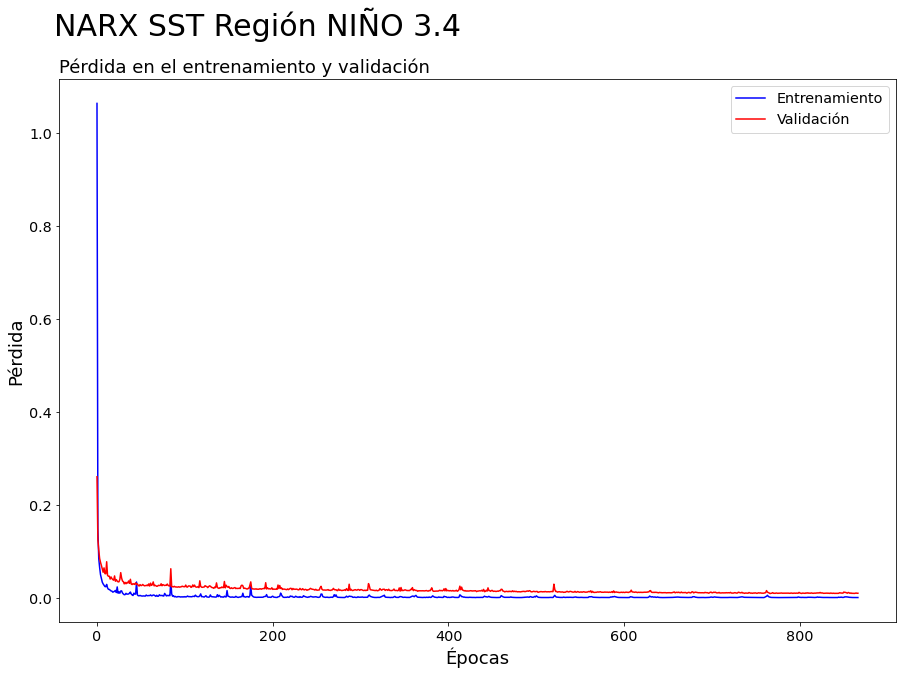

In [10]:
training_model.training_model(model=model,
                            epochs = epochs,
                            validation_split = validation_split,
                            callbacks = [es_callback, modelckpt_callback])

training_model.model.summary()


training_model.loss_plot(title='NARX SST Región NIÑO 3.4',
                        path='./figure/nino34/loss_narx_model_nino34.png')

Validando resultados

<AxesSubplot:>

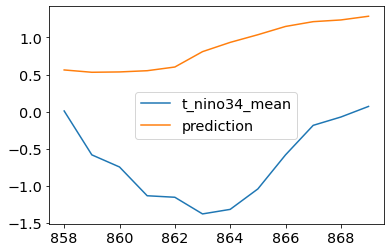

In [11]:
training_model.validation_test(batch_size)

training_model.pd_validation[training_model.pd_validation.type=='validation'][[y_output,'prediction']].plot()

In [12]:
pd_summary = training_model.pd_validation.copy()
pd_summary['nino34_mean'] = (data_std[data_std.index=='nino34_mean'][0]*pd_summary.t_nino34_mean) + data_mean[data_mean.index=='nino34_mean'][0]
pd_summary['prediction_nino34_mean'] = (data_std[data_std.index=='nino34_mean'][0]*pd_summary.prediction) + data_mean[data_mean.index=='nino34_mean'][0]


pd_summary

,periodo,t_nino34_mean,t_nino34_mean_exogena,prediction,type,nino34_mean,prediction_nino34_mean
0,1950-01-01,-2.380617,-2.380617,NaN,training,24.56,NaN
1,1950-02-01,-1.859887,-1.859887,NaN,training,25.07,NaN
2,1950-03-01,-1.032845,-1.032845,NaN,training,25.88,NaN
3,1950-04-01,-0.614219,-0.614219,NaN,training,26.29,NaN
4,1950-05-01,-0.716323,-0.716323,NaN,training,26.19,NaN
...,...,...,...,...,...,...,...
865,2022-02-01,-1.043056,-1.043056,1.036876,validation,25.87,27.907074
866,2022-03-01,-0.583588,-0.583588,1.148561,validation,26.32,28.016457
867,2022-04-01,-0.185383,-0.185383,1.213124,validation,26.71,28.079690
868,2022-05-01,-0.073069,-0.073069,1.236104,validation,26.82,28.102197


<AxesSubplot:>

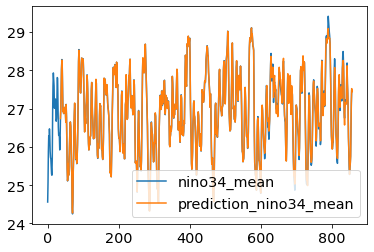

In [13]:
pd_summary[pd_summary.type=='training'][['nino34_mean','prediction_nino34_mean']].plot()

<AxesSubplot:>

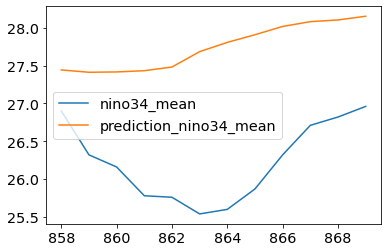

In [14]:
pd_summary[pd_summary.type=='validation'][['nino34_mean','prediction_nino34_mean']].plot()